In [1]:
#imports 
import cv2 
import matplotlib.pyplot as plt
import numpy as np
from skimage.draw import line
# from skimage import guassian


# Reading map

(400, 680, 3)


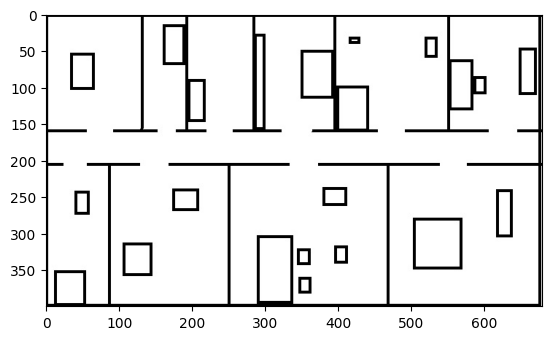

In [3]:
#read the map
map=cv2.imread('./Map.jpg')
#convert to grayscale
map=cv2.cvtColor(map, cv2.COLOR_BGR2RGB)
#make map black and white
print(map.shape)
# print(map)
# map[100][100:104]=(255,0,0)
# map[101][100:104]=(255,0,0)
# map[102][100:104]=(255,0,0)
# map[103][100:104]=(255,0,0)
#show the map
plt.imshow(map)


# Problem 1

[44.28317965096906, 44.721359549995796, 45.65084884205331, 46.647615158762406, 47.70744176750625, 48.82622246293481, 50.0, 51.22499389946279, 53.150729063673246, 54.48853090330111, 56.568542494923804, 58.728187440104094, 60.959002616512684, 63.25345840347388, 66.40030120413611, 68.81860213634101, 72.94518489934754, 77.17512552629896, 80.1311425102625, 161.90120444270946, 158.8238017426859, 156.7801007781281, 154.50566332662373, 120.48651376813922, 135.05924625881784, 152.34500319997372, 174.64249196572982, 202.7856010667424, 247.09714688761585, 299.29584026511293, 299.220654367308, 299.42778762165676, 299.06019460971396, 270.04629232781554, 79.1012010022604, 52.23983154643591, 38.3275357934736, 29.427877939124322, 24.515301344262525, 20.615528128088304, 17.72004514666935, 15.811388300841896, 18.027756377319946, 13.0, 14.317821063276353, 15.652475842498529, 10.295630140987, 11.661903789690601, 13.038404810405298, 8.602325267042627, 10.0, 7.810249675906654, 9.219544457292887, 10.63014581

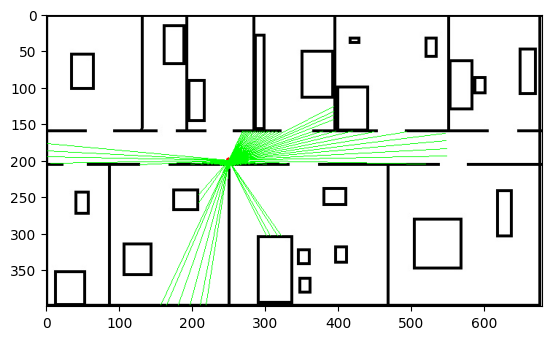

In [3]:
distances=[]
def draw_rays(x,y,theta,max_measurement=1200,map=map,opening_angle=250,step=2):
    max_measurement = max_measurement//4
    # map[y][x:x+4]=(255,0,0)
    # map[y+1][x:x+4]=(255,0,0)
    # map[y+2][x:x+4]=(255,0,0)
    # map[y+3][x:x+4]=(255,0,0)
    cv2.circle(map,(x,y),4,(255,0,0),thickness=-4)
    for i in range(-opening_angle//2,(opening_angle//2)+1,step):
        end_x = int(x + max_measurement * np.cos(np.radians(theta + i)))
        end_y = int(y + max_measurement * np.sin(np.radians(theta + i)))
        #draw line
        pixelx,pixely=line(x,y,end_x,end_y)
        # print(pixelx)
        # print(pixely)
        for index_x,index_y in zip(pixelx,pixely):
            if index_x>=0 and index_x<map.shape[1] and index_y>=0 and index_y<map.shape[0]:
                # print((map[index_x][index_y]))
                if np.array_equal(map[index_y, index_x], [0, 0, 0]):
                    end_x=index_x
                    end_y=index_y
                    break
        
        cv2.line(map,(x,y),(end_x,end_y),(0,255,0),1)
        distances.append(np.sqrt((end_x-x)**2+(end_y-y)**2))   
    return map
map=cv2.imread('./Map.jpg')
map = draw_rays(250, 200, 60, map=map)
plt.imshow(map)
print(distances)

In [36]:
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()


# Problem 2

In [74]:

map=cv2.imread('./Map.jpg')
img=cv2.cvtColor(map, cv2.COLOR_BGR2RGB)
_, map = cv2.threshold(cv2.cvtColor(map, cv2.COLOR_RGB2GRAY), 128, 1, cv2.THRESH_BINARY)

map=1-map
# #want to convert it to grayscale
map=cv2.GaussianBlur(map,(11,11),0)
# map+=0.01
#add 0.01 to the map
map=(map+0.0001)
map=map/map.max()
print(map)
# show_images([map],['map'])
cv2.imshow('map',map)


[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1272: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


In [ ]:
#preparing the map to be like the likelihood field
# converting white to black and vice versa
map=cv2.imread('./Map.jpg')
img=cv2.cvtColor(map, cv2.COLOR_BGR2RGB)
_, map = cv2.threshold(cv2.cvtColor(map, cv2.COLOR_RGB2GRAY), 128, 1, cv2.THRESH_BINARY)

map=1-map
# #want to convert it to grayscale
map=cv2.GaussianBlur(map,(5,5),0)
# map+=0.01
#add 0.01 to the map
map=(map+0.001)
map=map/map.max()

def find_robot_pose(map, distances):
    position_x = 0
    position_y = 0
    orientation = 0
    max_theta_probability = 0
    max_probability = float("-inf")
    max_probablity_for_theta = []
    theta_probablity = 1
    max_prob_map = map  # Map for storing max probabilities
    max_pos=(0,0,0)
    for y in range(0, map.shape[0], 4):
        for x in range(0, map.shape[1], 4):
            if map[y][x]==1.0:
                continue
            all_theta_probablities = []
            for theta in range(-125, 125, 2):
                proababilites=1.0
                for dist in distances:
                    end_x = ((x + dist * np.cos(np.radians(theta)))).astype(int)
                    end_y = ((y + dist * np.sin(np.radians(theta)))).astype(int)
                    if end_x >= map.shape[1] or  end_y >= map.shape[0]:
                        proababilites*=0.0001
                        continue
                    else:
                        # if map[end_y][end_x]==1.0 or map[end_y][end_x]==0.0:
                        #     continue
                        moseba=proababilites
                        proababilites*=map[end_y][end_x]
                        # if proababilites==0:
                            # print(f"probab 2bl el moseba {moseba}")
                            # print(f"map b {map[end_y][end_x]}")
                            # print("ya lahwy ")
                            # break
                        # print(proababilites)
                        
                if (end_x < map.shape[1] and  end_y < map.shape[0]) and map[y][x]==1:
                    continue
                proababilty_all_distances_one_theta=proababilites
                # print(f"probab : {proababilty_all_distances_one_theta}")
                all_theta_probablities.append(proababilty_all_distances_one_theta)
                if proababilty_all_distances_one_theta > max_probability:
                    max_probability=proababilty_all_distances_one_theta
                    max_pos=(x,y,theta)
                    print(f"max_pos is ({x},{y},{theta}) with probability of {max_probability}")
                if end_y<map.shape[0] and end_x<map.shape[1] :
                    if proababilty_all_distances_one_theta >map[y][x]:
                        map[y][x]=proababilty_all_distances_one_theta
                    max_postions=np.max(all_theta_probablities)
                    map[y][x]=max_postions
            
    print(f"Position: ({max_pos[0]}, {max_pos[1]}), Orientation: {max_pos[2]} with max probability: {max_probability}")
    position_p = np.zeros((map.shape[0], map.shape[1]))
    position_p[max_pos[1], max_pos[0]] = 255
    return map,position_p

print(map)
new_map, position = find_robot_pose(map, distances)
plt.imshow(map, cmap="gray")
plt.imshow(position, cmap="gray")
# print(new_map)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
max_pos is (4,4,-125) with probability of 0.0
max_pos is (4,4,-113) with probability of 9.01272131136e-313
max_pos is (4,4,-101) with probability of 9.066933010422214e-295
max_pos is (4,4,-99) with probability of 9.287060324387422e-223
max_pos is (4,4,-97) with probability of 9.493535332711842e-157
max_pos is (4,4,-95) with probability of 9.598487935385534e-124
max_pos is (4,4,-93) with probability of 9.90054780713005e-31
max_pos is (4,4,-1) with probability of 1.0


KeyboardInterrupt: 

10 10 220 9.942170758321235e-233
390 10 330 9.943164975397067e-229
390 20 330 9.944159291894606e-225
280 30 330 9.949132366055926e-205
400 60 150 9.956098848378213e-177
400 70 150 9.961077893511849e-157
400 80 150 9.965062922373771e-141
400 90 150 9.966059428666008e-137
390 110 330 9.969049545486356e-125
390 120 330 9.972040559431457e-113
240 200 60 9.9730377634874e-109
250 200 60 9.990005497800719e-41
Position: (250, 200), Orientation: 60 with max probability: 9.990005497800719e-41


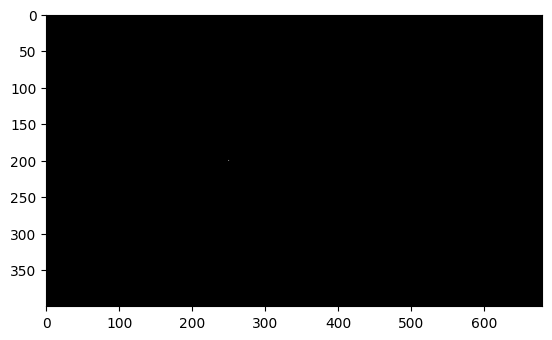

In [4]:
from math import sin,cos,pi

map=cv2.imread('./Map.jpg')
img=cv2.cvtColor(map, cv2.COLOR_BGR2RGB)
_, map = cv2.threshold(cv2.cvtColor(map, cv2.COLOR_RGB2GRAY), 128, 1, cv2.THRESH_BINARY)

map=1-map
# #want to convert it to grayscale
map=cv2.GaussianBlur(map,(3,3),0)
# map+=0.01
#add 0.01 to the map
map=(map+0.0001)
map=map/map.max()


def find_robot_pose(map, distances):
    position_x = 0
    position_y = 0
    the_desired_orientation = 0
    max_theta_probability = 0
    max_probability = 0
    max_probablity_for_theta = []
    theta_probablity = 0
    max_prob_map =map # Map for storing max probabilities

    for y in range(0, map.shape[0], 10):
        for x in range(0, map.shape[1], 10):
            if map[y][x]==1.0:
                continue
            all_theta_probablities = []
            theta_wanted=[]
            for theta in range(0, 360, 10):
                index=0
                product=1.0
                for angle in range(theta-125,theta+125,2):
                    probablities = []
                    # vectorize the code
                    end_x = ((x + distances[index] * np.cos(np.radians(angle)))).astype(
                        int
                    )
                    end_y = ((y + distances[index] * np.sin(np.radians(angle)))).astype(
                        int
                    )
                    if end_x>=map.shape[1] or end_y>=map.shape[0]:
                            product*=0.00001
                    else:
                        product*=map[end_y,end_x] 
                    # print((end_x))
                        
                        # print(product)
                    # print(product)
                    # print(probablities_local)
                    # print(product)
                    # print(len(probablities))

                    # multiply all probablities with each  other
                    # if product==1:
                    #     continue
                    index+=1
                all_theta_probablities.append(product)
                theta_wanted.append(theta)
                
            max_theta_probability = max(all_theta_probablities)
            orientation= np.argmax(all_theta_probablities)
            orientation=theta_wanted[orientation]


            # Update global max probability and orientation
            if max_theta_probability > max_probability:
                max_probability = max_theta_probability
                position_x, position_y = x, y
                the_desired_orientation = orientation
                print(position_x, position_y, the_desired_orientation,max_probability)
            
            map[y, x] = max_theta_probability
        
            # find the position
    # position_y,position_x=np.unravel_index(np.argmax(map),map.shape)

    # map[y][x]=max_probablity
    # position_x=x
    # position_y=y
    # orientation=all_theta_probablities.index(max_probablity)*2
    # print(position_x, position_y, orientation)

    position_p = np.zeros((map.shape[0], map.shape[1]))
    position_p[position_y, position_x] = 255
    print(f"Position: ({position_x}, {position_y}), Orientation: {the_desired_orientation} with max probability: {max_probability}")

    return map, position_p

new_map, position = find_robot_pose(map, distances)
plt.imshow(map, cmap="gray")
plt.imshow(position, cmap="gray")
# print(new_map)

255.0
200 250


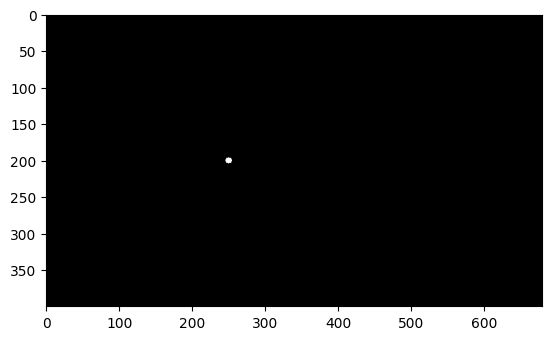

In [5]:
# print(map.shape)
#max of the map
# Dilate image
circle_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9 ,9))
# Dilate the image using the circular structuring element
dilated_image = cv2.dilate(position, circle_kernel)
print(np.max(position))
y,x=np.unravel_index(np.argmax(position),position.shape)
print(y,x)
plt.imshow(dilated_image,cmap='gray')